# Anchor Editing Demonstration

## Boilerplate Code

In [9]:
import os, sys
sys.path.append(os.getcwd())
sys.path.append(os.getcwd() + '/..')
sys.path.append(os.getcwd() + '/../..')
sys.path.append(os.getcwd() + '/../lib')
sys.path.append(os.getcwd() + '/../../lib')

from vtkplotter import *
import k3d
embedWindow(backend="k3d")

from lib.mesh_util import load_triangular_mesh, present_mesh
from lib.laplacian_operations import *
from lib.laplacian_beltrami import LaplaceBeltramiWeighting
from vtkplotter import *
from trimesh import Trimesh
import numpy as np
from scipy import sparse


print('Demo Ready.')

Demo Ready.


## Available Meshes

In [5]:
OLAF = r"/Users/orperel/personal/tau/spectral_modeling/models/olafdidofranza/File/OBj/Studio Pose OLAF.obj"
BATMAN = r"/Users/orperel/personal/tau/spectral_modeling/models/batman/batman.obj"
TEAPOT = r"/Users/orperel/personal/tau/spectral_modeling/models/teapot/teapot.obj"
DEER = r"/Users/orperel/personal/tau/spectral_modeling/models/lowpolydeer/deer.obj"
HUMAN = r"/Users/orperel/personal/tau/spectral_modeling/models/human/sculpt.obj"
OGRE = r"/Users/orperel/personal/tau/spectral_modeling/models/ogre/OgreOBJ.obj"

mesh_path = DEER

## Anchor Editing

### Introduction

The block demonstrates the effect of mesh editting using anchors and the Laplacian-Beltrami operator.

In this scenario, the user marks specific vertices in the mesh as anchors (pink). <br>
The user proceeds to transforms them to a new position (yellow). <br>
Then, a linear system consisting of Laplace-Beltrami differential coordinates & anchor constraints is solved. <br>
As a result, new global coordinates are calculated for the mesh. <br>

To ensure the new global coordinates maintain the original shape, we define fixed anchors whose position must remain
stationary.

<br>
Note I: The following code blocks are optimized to demonstrate a predefined transformation for the DEER model. <br>
Note II: To increase numerical stability, we remove the horns here and demonstrates results on the body of the main connected component (when multiple bodies appear within the mesh, more constraints are required to ensure each body has boundry conditions as Laplace Beltrami only represents differential coordinates).

In [19]:
embedWindow(backend="k3d")
mesh = load_triangular_mesh(mesh_path, keep_only_largest_component=True)
deer_fixed_anchors_idx = [386, 138, 155, 14, 219, 305, 371, 215, 59, 349, 63, 125, 206]
deer_anchor_idx = [426, 387]
transformation = np.array((200.0, 130.0, 0.0))

def display_deer(mesh, markers=None):
    mesh = trimesh2vtk(mesh)
    plot = k3d.plot(camera_auto_fit=False)
    plot.mode = "Callback"
    mesh_obj = k3d.vtk_poly_data(mesh.polydata(), color=0x555555)
    plot += mesh_obj
    for marker in markers:
        plot += marker
    plot.camera = [520.6562972491787, 191.68615010607436, 1215.5251759565629,
                   198.03657032995727, 551.0127651644228, -0.6431916104922732,
                   -0.11466002800683134, 0.9388108450740459, 0.324788046499266]
    plot.display()
    

min_avg_edge_size = min(mesh.edges_unique_length)
fixed_anchor_points = k3d.points(positions=mesh.vertices[deer_fixed_anchors_idx],
                           point_size=min_avg_edge_size * 2,
                           color=0x00ffff)
anchor_points = k3d.points(positions=mesh.vertices[deer_anchor_idx],
                           point_size=min_avg_edge_size * 2,
                           color=0xff00ff)
transformed_coords = mesh.vertices[deer_anchor_idx] + transformation
transformed_anchor_points = k3d.points(positions=transformed_coords,
                                       point_size=min_avg_edge_size * 2,
                                       color=0xffff00)


display_deer(mesh, markers=[anchor_points, fixed_anchor_points, transformed_anchor_points])

Output()

### Anchor editing with "umbrella" weighting

In [21]:
embedWindow(backend="k3d")
mesh = load_triangular_mesh(DEER, keep_only_largest_component=True)

anchor_idx = deer_fixed_anchors_idx + deer_anchor_idx
fixed_anchor_pos = mesh.vertices[deer_fixed_anchors_idx]
transformed_anchors = mesh.vertices[deer_anchor_idx] + transformation
anchors = np.concatenate((fixed_anchor_pos, transformed_coords), axis=0)

solve_laplace_matrix(mesh, anchors=anchors, anchor_idx=anchor_idx,
                     weighting_scheme=LaplaceBeltramiWeighting.UMBRELLA,
                     anchors_weight=DEFAULT_ANCHOR_WEIGHT)

display_deer(mesh, markers=[anchor_points, fixed_anchor_points, transformed_anchor_points])

Output()

### Anchor editing with "cotangent" weighting (no area normalization)

In [22]:
embedWindow(backend="k3d")
mesh = load_triangular_mesh(DEER, keep_only_largest_component=True)

anchor_idx = deer_fixed_anchors_idx + deer_anchor_idx
fixed_anchor_pos = mesh.vertices[deer_fixed_anchors_idx]
transformed_anchors = mesh.vertices[deer_anchor_idx] + transformation
anchors = np.concatenate((fixed_anchor_pos, transformed_coords), axis=0)

solve_laplace_matrix(mesh, anchors=anchors, anchor_idx=anchor_idx,
                     weighting_scheme=LaplaceBeltramiWeighting.COTANGENT_NO_AREA,
                     anchors_weight=DEFAULT_ANCHOR_WEIGHT)

display_deer(mesh, markers=[anchor_points, fixed_anchor_points, transformed_anchor_points])

Output()

### Anchor editing with "cotangent" weighting (voronoi cell normalization)

In [25]:
embedWindow(backend="k3d")
mesh = load_triangular_mesh(DEER, keep_only_largest_component=True)

anchor_idx = deer_fixed_anchors_idx + deer_anchor_idx
fixed_anchor_pos = mesh.vertices[deer_fixed_anchors_idx]
transformed_anchors = mesh.vertices[deer_anchor_idx] + transformation
anchors = np.concatenate((fixed_anchor_pos, transformed_coords), axis=0)

solve_laplace_matrix(mesh, anchors=anchors, anchor_idx=anchor_idx,
                     weighting_scheme=LaplaceBeltramiWeighting.COTANGENT_VORONOI_CELL,
                     anchors_weight=DEFAULT_ANCHOR_WEIGHT)

display_deer(mesh, markers=[anchor_points, fixed_anchor_points, transformed_anchor_points])

Output()

### Anchor editing with "cotangent" weighting (one third of vertex cell area approximation)

In [24]:
embedWindow(backend="k3d")
mesh = load_triangular_mesh(DEER, keep_only_largest_component=True)

anchor_idx = deer_fixed_anchors_idx + deer_anchor_idx
fixed_anchor_pos = mesh.vertices[deer_fixed_anchors_idx]
transformed_anchors = mesh.vertices[deer_anchor_idx] + transformation
anchors = np.concatenate((fixed_anchor_pos, transformed_coords), axis=0)

solve_laplace_matrix(mesh, anchors=anchors, anchor_idx=anchor_idx,
                     weighting_scheme=LaplaceBeltramiWeighting.COTANGENT_ONE_THIRD_TRIANGLE,
                     anchors_weight=DEFAULT_ANCHOR_WEIGHT)

display_deer(mesh, markers=[anchor_points, fixed_anchor_points, transformed_anchor_points])

Output()

## Interactive Hyperparameters Edit

Set the plot in "callback" mode, to be able to select anchors to transform (red -> blue).
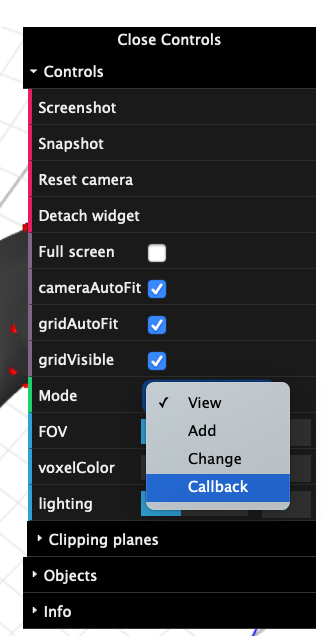

One done, click solve to obtain results. <br>
Note: Additional runs require reloading the block

In [26]:
import k3d
import json 
import ipywidgets as widgets
from ipywidgets import Button, ToggleButton
from trimesh.proximity import ProximityQuery
import copy
    
mesh_to_process = load_triangular_mesh(mesh_path, keep_only_largest_component=True)

kd_tree = ProximityQuery(mesh_to_process)
state = dict(
    NON_SELECTED_COLOR=0xff0000,
    SELECTED_COLOR=0x0000ff,
    HOVER_COLOR=0x00ff00,
    prev_selected_point_id=set(),
    prev_hovered_point_id=None
)

min_avg_edge_size = min(mesh_to_process.edges_unique_length)
points_color = [state['NON_SELECTED_COLOR'] for _ in range(len(mesh_to_process.vertices))]
plt_points = k3d.points(positions=mesh_to_process.vertices, point_size=min_avg_edge_size,
                        colors=points_color)

def select_nearest(params, is_select):
    prev_selected_point_id = state['prev_selected_point_id']
    prev_hovered_point_id = state['prev_hovered_point_id']
    NON_SELECTED_COLOR = state['NON_SELECTED_COLOR']
    SELECTED_COLOR = state['SELECTED_COLOR']
    HOVER_COLOR = state['HOVER_COLOR']    
    
    click_point = params['position']
    query_reply = kd_tree.vertex(click_point)
    distance, closest_vertex_id = query_reply
    
    if is_select:
        if points_color[closest_vertex_id] == HOVER_COLOR:
            prev_hovered_point_id = None
        if closest_vertex_id not in prev_selected_point_id:
            points_color[closest_vertex_id] = SELECTED_COLOR
            prev_selected_point_id.add(closest_vertex_id)
        else:
            points_color[closest_vertex_id] = HOVER_COLOR
            prev_selected_point_id.remove(closest_vertex_id)
            prev_hovered_point_id = closest_vertex_id            
    else:
        if prev_hovered_point_id is not None:
            points_color[prev_hovered_point_id] = NON_SELECTED_COLOR
            prev_hovered_point_id = None
        if points_color[closest_vertex_id] == NON_SELECTED_COLOR:
            prev_hovered_point_id = closest_vertex_id
            points_color[closest_vertex_id] = HOVER_COLOR            
    plt_points.colors = points_color
    
    state['prev_selected_point_id'] = prev_selected_point_id
    state['prev_hovered_point_id'] = prev_hovered_point_id

def on_mesh_click(params):
    select_nearest(params, is_select=True)
    
def on_mesh_hover(params):
    select_nearest(params, is_select=False)
    
def on_clear(params):
    global points_color
    points_color = [state['NON_SELECTED_COLOR'] for _ in range(len(mesh_to_process.vertices))]    
    plt_points.colors = points_color
    state['prev_selected_point_id'].clear()
    state['prev_hovered_point_id'] = None
    
def on_solve_laplace(params):
    global mesh_to_process, plot, mesh_obj, plt_points
    amount = 1000
    anchor_idx = np.array(list(state['prev_selected_point_id']))
    anchors = [mesh_to_process.vertices[v_id] + np.array((0, -amount, 0)) for v_id in anchor_idx]

    solve_laplace_matrix(mesh, anchors=anchors, anchor_idx=anchor_idx,
                         weighting_scheme=LaplaceBeltramiWeighting.COTANGENT_NO_AREA,
                         anchors_weight=DEFAULT_ANCHOR_WEIGHT)
    
    
    # Refresh display
    plot -= mesh_obj
    output_mesh = trimesh2vtk(mesh_to_process)
    mesh_obj = k3d.vtk_poly_data(output_mesh.polydata(), color=0x333333)
    
    mesh_obj.click_callback = on_mesh_click
    mesh_obj.hover_callback = on_mesh_hover
    plot += mesh_obj
    plot -= plt_points
    
clean_btn = Button(
    description='Clear Anchors',
    button_style='',
    tooltip='Clear currently selected anchors'
)
clean_btn.on_click(on_clear)
display(clean_btn)

solve_btn = Button(
    description='Solve',
    button_style='',
    tooltip='Clear currently selected anchors'
)
solve_btn.on_click(on_solve_laplace)
display(solve_btn)

output_mesh = trimesh2vtk(mesh_to_process)

plot = k3d.plot()
plot.mode = "Callback"
mesh_obj = k3d.vtk_poly_data(output_mesh.polydata(), color=0x555555)
mesh_obj.click_callback = on_mesh_click
mesh_obj.hover_callback = on_mesh_hover
plot += mesh_obj
plot += plt_points
plot.display()

/usr/local/anaconda3/envs/spectral_modeling/lib/python3.7/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Button(description='Clear Anchors', style=ButtonStyle(), tooltip='Clear currently selected anchors')

Button(description='Solve', style=ButtonStyle(), tooltip='Clear currently selected anchors')

Output()

[253  61]
